In [1]:
import polars as pl
import pandas as pd
import numpy as np
import pyarrow as pa
import plotly.express as px
import string
import random
import os
from datetime import datetime

# Motivation
Each of the following, alone(!), is amazing.

1. Small memory footpring
  - Native dtypes: missing, strings.
  - Arrow format in memory.

1. Lazy evaluation allows query Planning.

1. Out of the box parallelism: Fast and informative mesages for debugging.

1. Strict typing: This means the dtype of output is defined by the operation and not bu the input. This is both safers, and allows static analysis.



## Memory Footprint


### Memory Footprint of Storage

Polars vs. Pandas:

In [2]:
letters = pl.Series(list(string.ascii_letters))

n = int(10e6)
letter1 = letters.sample(n,with_replacement=True)
letter1.estimated_size(unit='gb')

0.08381903916597366

In [3]:
letter1_pandas = letter1.to_pandas() 
letter1_pandas.memory_usage(deep=True, index=False) / 1e9

0.58

The memory footprint of the polars Series is 1/7 of the pandas Series(!).
But I did cheat- I used string type data to emphasize the difference. The difference would have been smaller if I had used integers or floats. 




### Memory Footprint of Compute

You are probably storing your data to compute with it.
Let's compare the memory footprint of computations. 


In [4]:
%load_ext memory_profiler

In [5]:
%memit letter1.sort()

peak memory: 539.75 MiB, increment: 210.87 MiB


In [6]:
%memit letter1_pandas.sort_values()

peak memory: 713.17 MiB, increment: 383.79 MiB


In [7]:
%memit letter1[10]='a'

peak memory: 468.66 MiB, increment: 53.14 MiB


In [8]:
%memit letter1_pandas[10]='a'

peak memory: 416.72 MiB, increment: 0.00 MiB


Things to notice:

- Operating on existing data consumes less memory in polars than in pandas.
- Changing the data consumes more memory in polars than in pandas. Why is that?


### Operating From Disk to Disk

What if my data does not fit into RAM?
Turns out you can read from disk, process in RAM, and write to disk. This allows you to process data larger than your memory. 

TODO: demonstrate sink_parquet from [here](https://www.rhosignal.com/posts/sink-parquet-files/).





## Query Planning

Consider a sort opperation that follows a filter operation. 
Ideally, filter precededs the sort, but we did not ensure this...
We now demonstarte that polars' query planner will do it for you. 
En passant, we see polars is more efficient also without the query planner. 


Polars' Eager evaluation, without query planning. 
Sort then filter. 

In [9]:
%timeit -n 2 -r 2 letter1.sort().filter(letter1.is_in(['a','b','c']))

663 ms ± 2.83 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Polars' Eager evaluation, without query planning. 
Filter then sort. 

In [10]:
%timeit -n 2 -r 2 letter1.filter(letter1.is_in(['a','b','c'])).sort()

204 ms ± 379 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


Polars' Lazy evaluation with query planning. 
Recieves sort then filter; executes filter then sort. 

In [11]:
%timeit -n 2 -r 2 letter1.alias('letters').to_frame().lazy().sort(by='letters').filter(pl.col('letters').is_in(['a','b','c'])).collect()

207 ms ± 14.2 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Pandas' eager evaluation in the wrong order: Sort then filter. 

%timeit -n 2 -r 2 letter1_pandas.sort_values().loc[lambda x: x.isin(['a','b','c'])]
```


Pandas eager evaluation in the right order: Filter then sort. 

In [12]:
%timeit -n 2 letter1_pandas.loc[lambda x: x.isin(['a','b','c'])].sort_values()

701 ms ± 8.33 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


Pandas alternative syntax, just as slow. 

In [13]:
%timeit -n 2 -r 2 letter1_pandas.loc[letter1_pandas.isin(['a','b','c'])].sort_values()

701 ms ± 2.03 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Things to note:

1. Query planning works!
1. Polars faster than Pandas even in eager evaluation (without query planning).



## Parallelism

Polars seamlessly parallelizes over columns (also within, when possible).
As the number of columns in the data grows, we would expect fixed runtime until all cores are used, and then linear scaling.
The following code demonstrates this idea, using a simple sum-within-column.


In [14]:
import time

def scaling_of_sums(n_rows, n_cols):
  # n_cols = 2
  # n_rows = int(1e6)
  A = {}
  A_numpy = np.random.randn(n_rows,n_cols)
  A['numpy'] = A_numpy.copy()
  A['polars'] = pl.DataFrame(A_numpy)
  A['pandas'] = pd.DataFrame(A_numpy)

  times = {}
  for key,value in A.items():
    start = time.time()
    value.sum()
    end = time.time()
    times[key] = end-start

  return(times)

In [15]:
scaling_of_time = {
  p:scaling_of_sums(n_rows= int(1e6),n_cols = p) for p in np.arange(1,16)}

In [16]:
data = pd.DataFrame(scaling_of_time).T
px.line(
  data, 
  labels=dict(
    index="Number of Columns", 
    value="Runtime")
)

Things to note:

- Pandas is slow. 
- Numpy is quite efficient.
- My machine has 8 cores. I would thus expect a fixed timing until 8 columns, and then linear scaling. This is not the case. I wonder why?


## Speed Of Import

Polar's `read_x` functions are quite faster than Pandas. 
This is due to better type "guessing" heuristics, and to native support of the parquet file format. 

We now make synthetic data, save it as csv or parquet, and reimport it with polars and pandas.

Starting with CSV:

In [17]:
n_rows = int(1e5)
n_cols = 10
data = np.random.randn(n_rows,n_cols)
data.tofile('data/data.csv', sep = ',')

Import with pandas. 

In [18]:
%timeit -n2 -r2 data_pandas = pd.read_csv('data/data.csv', header = None)

19.1 s ± 97 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Import with polars. 

In [19]:
%timeit -n2 -r2 data_polars = pl.read_csv('data/data.csv', has_header = False)

3.25 s ± 451 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Moving to parquet:


In [20]:
data_pandas = pd.DataFrame(data)
data_pandas.columns = data_pandas.columns.astype(str)
data_pandas.to_parquet('data/data.parquet', index = False)

In [21]:
%timeit -n2 -r2 data_pandas = pd.read_parquet('data/data.parquet')

15.7 ms ± 2.08 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [22]:
%timeit -n2 -r2 data_polars = pl.read_parquet('data/data.parquet')

9.2 ms ± 509 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


Things to note:

- The difference in speed is quite large.
- I dare argue that polars' type guessing is better, but I am not demonstrating it here. 
- Bonus fact: parquet is much faster than csv, and also saves the frame's schema.



## Speed Of Join

Because pandas is built on numpy, people see it as both an in-memory database, and a matrix/array library.
With polars, it is quite clear it is an in-memory database, and not an array processing library (despite having a `pl.dot()` function for inner products).
As such, you cannot multiply two polars dataframes, but you can certainly join then efficiently.

Make some data:

In [23]:
def make_data(n_rows, n_cols):
  data = np.concatenate(
  (
    np.arange(n_rows)[:,np.newaxis], # index
    np.random.randn(n_rows,n_cols), # values
    ),
    axis=1)
    
  return data


n_rows = int(1e6)
n_cols = 10
data_left = make_data(n_rows, n_cols)
data_right = make_data(n_rows, n_cols)

Polars join:

In [24]:
data_left_polars = pl.DataFrame(data_left)
data_right_polars = pl.DataFrame(data_right)

%timeit -n2 -r2 polars_joined = data_left_polars.join(data_right_polars, on = 'column_0', how = 'inner')

249 ms ± 35.9 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Pandas join:

In [25]:
data_left_pandas = pd.DataFrame(data_left)
data_right_pandas = pd.DataFrame(data_right)

%timeit -n2 -r2 pandas_joined = data_left_pandas.merge(data_right_pandas, on = 0, how = 'inner')

747 ms ± 73.8 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## Moving Forward...

If this motivational seection has convinced you to try polars instead of pandas, here is a  more structured intro. 






# Polars Series

Much like pandas, polars' fundamental building block is the series. 
A series is a column of data, with a name, and a dtype.
In the following we:

1. Create a series and demonstrate basic operations on it.
1. Demonstrate the various dtypes. 
1. Discuss missing values.
1. Filter a series.

## Series Housekeeping
Construct a series

In [26]:
s = pl.Series("a", [1, 2, 3])
s

a
i64
1
2
3


Make pandas series for comparison:

In [27]:
s_pandas = pd.Series([1, 2, 3], name = "a")

In [28]:
type(s)

polars.internals.series.series.Series

In [29]:
type(s_pandas)

pandas.core.series.Series

In [30]:
s.dtype

Int64

In [31]:
s_pandas.dtype

dtype('int64')

Renaming a series; will be very useful when operating on dataframe columns.

In [32]:
s.alias("b")

b
i64
1
2
3


In [33]:
s.clone()

a
i64
1
2
3


In [34]:
s.clone().append(pl.Series("a", [4, 5, 6]))

a
i64
1
2
3
4
5
6


Note: `series.append` operates in-place. That is why we cloned the series first.

Flatten a list of lists using `explode()`.

In [35]:
pl.Series("a", [[1, 2], [3, 4], [9, 10]]).explode()

a
i64
1
2
3
4
9
10


In [36]:
s.extend_constant(666, n=2)

a
i64
1
2
3
666
666


In [37]:
#| eval: false
s.new_from_index()

In [38]:
s.rechunk()

a
i64
1
2
3


In [39]:
s.rename("b", in_place=False) # has an in_place option. Unlike .alias()

b
i64
1
2
3


In [40]:
s.to_dummies()

a_1,a_2,a_3
u8,u8,u8
1,0,0
0,1,0
0,0,1


In [41]:
s.cleared() # creates an empty series, with same dtype

a
i64


Consturcting a series of floats, for later use.

In [42]:
f = pl.Series("a", [1., 2., 3.])
f

a
f64
1.0
2.0
3.0


In [43]:
f.dtype

Float64

## Memory Representation of Series

Object size in memory. Super useful for profiling:

In [44]:
s.estimated_size(unit="gb")

2.2351741790771484e-08

In [45]:
s.chunk_lengths() # what is the length of each memory chunk?

[3]

## Filtering and Subsetting


In [46]:
s[0]

1

Filtering with boolneas requires a series of booleans, not a list:

In [47]:
s.filter(pl.Series("a", [True, False, True])) # works

a
i64
1
3


Will not work:

In [48]:
#| eval: false

s[[True, False, True]]

Don't be confused with pandas!

In [49]:
#| eval: false

s.loc[[True, False, True]] 

In [50]:
s.head(2)

a
i64
1
2


In [51]:
s.limit(2)

a
i64
1
2


Negative indexing is not supported:

In [52]:
#| eval: false

s.head(-1)
s.limit(-1)

In [53]:
s.tail(2)

a
i64
2
3


In [54]:
s.sample(2, with_replacement=False)

a
i64
3
2


In [55]:
s.take([0, 2]) # same as .iloc

a
i64
1
3


In [56]:
s.slice(1, 2) # same as pandas .iloc[1:2]

a
i64
2
3


In [57]:
s.take_every(2)

a
i64
1
3


## Aggregations

In [58]:
s.sum()

6

In [59]:
s.min()

1

In [60]:
s.arg_min()

0

In [61]:
s.mean()

2.0

In [62]:
s.median()

2.0

In [63]:
s.entropy()

-4.68213122712422

In [64]:
s.describe()

statistic,value
str,f64
"""min""",1.0
"""max""",3.0
"""null_count""",0.0
"""mean""",2.0
"""std""",1.0
"""count""",3.0


In [65]:
s.value_counts()

a,counts
i64,u32
2,1
1,1
3,1


## Object Transformations


In [66]:
pl.Series("a",[1,2,3,4]).reshape(dims = (2,2))

a
list[i64]
"[1, 2]"
"[3, 4]"


In [67]:
s.shift(1)

a
i64
null
1
2


In [68]:
s.shift(-1)

a
i64
2
3
null


In [69]:
s.shift_and_fill(1, 999)

a
i64
999
1
2


## Mathematical Transformations

In [70]:
s.abs()

a
i64
1
2
3


In [71]:
s.sin()

a
f64
0.841471
0.909297
0.14112


In [72]:
s.exp()

a
f64
2.718282
7.389056
20.085537


In [73]:
s.hash()

a
u64
13321499719149775801
8196255364589999986
3071011010030224171


In [74]:
s.log()

a
f64
0.0
0.693147
1.098612


In [75]:
s.peak_max()

""
bool
false
false
true


In [76]:
s.sqrt()

a
f64
1.0
1.414214
1.732051


In [77]:
s.clip_max(2)

a
i64
1
2
2


In [78]:
s.clip_min(1)

a
i64
1
2
3


You cannot round integers, but you can round floats.


In [79]:
f.round(2)

a
f64
1.0
2.0
3.0


In [80]:
f.ceil()

a
f64
1.0
2.0
3.0


In [81]:
f.floor()

a
f64
1.0
2.0
3.0


In [82]:
s.is_in(pl.Series([1, 10]))

a
bool
true
false
false


__Caution__: `is_in()` in polars has an underscore, unlike `isin()` in pandas.



## Apply

Applying your own function:

In [83]:
s.apply(lambda x: x + 1)

a
i64
2
3
4


Using your own functions comes with a performance cost:

In [84]:
s1 = pl.Series(np.random.randn(int(1e5)))

%timeit -n2 -r2 s1+1

178 µs ± 47.4 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [85]:
%timeit -n2 -r2 s1.apply(lambda x: x + 1)

17.9 ms ± 1.1 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## Cummulative Operations


In [86]:
s.cummax()

a
i64
1
2
3


In [87]:
s.cumsum()

a
i64
1
3
6


In [88]:
s.cumprod()

a
i64
1
2
6


In [89]:
s.ewm_mean(com=0.5)

a
f64
1.0
1.75
2.615385


## Sequential Operations


In [90]:
s.diff()

a
i64
null
1
1


In [91]:
s.pct_change()

a
f64
null
1.0
0.5


## Windowed Operations


In [92]:
s.rolling_apply(
  pl.sum, 
  window_size=2)

a
i64
null
3
5


Not all functions will work within a `rolling_apply`! Only polars' functions will.

In [93]:
#| eval: false

s.rolling_apply(np.sum, window_size=2) # will not work

In [94]:
s.rolling_max(window_size=2)

a
i64
null
2
3


In [95]:
s.clip(1, 2)

a
i64
1
2
2


In [96]:
s.clone()

a
i64
1
2
3


In [97]:
# check equality with clone
s == s.clone()

a
bool
true
true
true


## Booleans


In [98]:
b = pl.Series("a", [True, True, False])
b.dtype

Boolean

In [99]:
b.all()

False

In [100]:
b.any()

True

## Uniques and Duplicates


In [101]:
s.is_duplicated()

a
bool
false
false
false


In [102]:
s.is_unique()

a
bool
true
true
true


In [103]:
s.n_unique()

3

In [104]:
pl.Series([1,2,3,4,1]).unique_counts()

""
u32
2
1
1
1


The first appearance of a value in a series:

In [105]:
pl.Series([1,2,3,4,1]).is_first()

""
bool
true
true
true
true
false


## dtypes

__Note__. Unlike pandas, polars' test functions have an underscore: `is_numeric()` instead of `isnumeric()`.


### Testing

In [106]:
s.is_numeric()

True

In [107]:
s.is_float()

False

In [108]:
s.is_utf8()

False

In [109]:
s.is_boolean()

False

In [110]:
s.is_datelike()

False

Compare with Pandas Type Checkers:

In [111]:
pd.api.types.is_string_dtype(s_pandas)

False

In [112]:
pd.api.types.is_string_dtype(s)

False

### Casting


In [113]:
s.cast(pl.Int32)

a
i32
1
2
3


Things to note: 

- `s.cast()` is an in place operation. If you want to keep the original series, you can use `s.cast(pl.Int32).clone()`.
- `cast()` is polars' equivalent of pandas' `astype()`.
- For a list of dtypes see the official [documentation](see https://pola-rs.github.io/polars/py-polars/html/reference/datatypes.html).



### Optimizing dtypes

Find the most efficient dtype for a series:

In [114]:
s.shrink_dtype()

a
i8
1
2
3


Also see [here](http://braaannigan.github.io/software/2022/10/31/polars-dtype-diet.html).

Shrink the memory allocation to the size of the actual data (in place).

In [115]:
s.shrink_to_fit() 

a
i64
1
2
3


## Ordering and Sorting 


In [116]:
s.sort()

a
i64
1
2
3


In [117]:
s.reverse()

a
i64
3
2
1


In [118]:
s.rank()

a
f32
1.0
2.0
3.0


In [119]:
s.arg_sort() 

a
u32
0
1
2


`arg_sort()` returns the indices that would sort the series. Same as R's `order()`.


In [120]:
s.sort() == s[s.arg_sort()]

a
bool
true
true
true


`arg_sort()` can also be used to return the original series from the sorted one:

In [121]:
s == s[s[s.arg_sort()].arg_sort()]

a
bool
true
true
true


In [122]:
s.shuffle(seed=1)

a
i64
2
1
3


## Missing

Pandas users will be excited to know that polars has built in missing value support (!) for all dtypes.
This has been a long awaited feature in the Python data science ecosystem, with implications on performance and syntax.


In [123]:
m = pl.Series("a", [1, 2, None, np.nan])
m.is_null()

a
bool
false
false
true
false


In [124]:
m.is_nan()

a
bool
false
false
null
true


In [125]:
m1 = pl.Series("a", [1, None, 2, ]) # python native None
m2 = pl.Series("a", [1, np.nan, 2, ]) # numpy's nan
m3 = pl.Series("a", [1, float('nan'), 2, ]) # python's nan
m4 = pd.Series([1, None, 2 ])
m5 = pd.Series([1, np.nan, 2, ])
m6 = pd.Series([1, float('nan'), 2, ])

In [126]:
[m1.sum(), m2.sum(), m3.sum(), m4.sum(), m5.sum(), m6.sum()]

[3, nan, nan, 3.0, 3.0, 3.0]

Things to note:

- The use of `is_null()` instead of pandas `isna()`.
- Polars supports `np.nan` but that is a different dtype than `None` (which is a `Null` type). `None` is not considered 
- Aggregating pandas and polars series behave differently w.r.t. missing values:
  - Both will ignore `None`; which is unsafe.
  - Polars will not ignore `np.nan`; which is safe. Pandas is unsafe w.r.t. `np.nan`, and will ignore it. 


Filling missing values; `None` and `np.nan` are treated differently:

In [127]:
m1.fill_null(0)

a
i64
1
0
2


In [128]:
m1.interpolate()

a
i64
1
1
2


In [129]:
m2.fill_null(0)

a
f64
1.0
NaN
2.0


In [130]:
m2.fill_nan(0)

a
f64
1.0
0.0
2.0


In [131]:
m1.drop_nulls()

a
i64
1
2


In [132]:
m1.drop_nans()

a
i64
1
null
2


In [133]:
m2.drop_nulls()

a
f64
1.0
NaN
2.0


## Export


In [134]:
s.to_frame()

a
i64
1
2
3


In [135]:
s.to_list()

[1, 2, 3]

In [136]:
s.to_numpy()

array([1, 2, 3])

In [137]:
s.to_pandas()

0    1
1    2
2    3
Name: a, dtype: int64

In [138]:
s.to_arrow()

[
  1,
  2,
  3
]

## Strings 
Like Pandas, accessed with the `.str` attribute.


In [139]:
st = pl.Series("a", ["foo", "bar", "baz"])

In [140]:
st.str.n_chars() # gets number of chars. In ASCII this is the same as lengths()

a
u32
3
3
3


In [141]:
st.str.lengths() # gets number of bytes in memory

a
u32
3
3
3


In [142]:
st.str.concat("-")

a
str
"""foo-bar-baz"""


In [143]:
st.str.contains("foo|tra|bar")

a
bool
true
true
false


In [144]:
st.str.count_match(pattern= 'o') # count literal metches

a
u32
2
0
0


Count pattern matches. 
Notice the `r"<regex pattern>"` syntax for regex (more about it [here](https://stackoverflow.com/questions/2241600/python-regex-r-prefix)). 

In [145]:
st.str.count_match(r"\w") # regex for alphanumeric

a
u32
3
3
3


In [146]:
st.str.ends_with("oo")

a
bool
true
false
false


In [147]:
st.str.starts_with("fo")

a
bool
true
false
false


To extract the first appearance of a pattern, use `extract`:

In [148]:
url = pl.Series("a", [
            "http://vote.com/ballon_dor?candidate=messi&ref=polars",

            "http://vote.com/ballon_dor?candidate=jorginho&ref=polars",

            "http://vote.com/ballon_dor?candidate=ronaldo&ref=polars"
            ])

url.str.extract(r"=(\w+)", 1)

a
str
"""messi"""
"""jorginho"""
"""ronaldo"""


To extract all appearances of a pattern, use `extract_all`:

In [149]:
url.str.extract_all("=(\w+)")

a
list[str]
"[""=messi"", ""=polars""]"
"[""=jorginho"", ""=polars""]"
"[""=ronaldo"", ""=polars""]"


In [150]:
st.str.ljust(8, "*")

a
str
"""foo*****"""
"""bar*****"""
"""baz*****"""


In [151]:
st.str.rjust(8, "*")

a
str
"""*****foo"""
"""*****bar"""
"""*****baz"""


In [152]:
st.str.lstrip('f')

a
str
"""oo"""
"""bar"""
"""baz"""


In [153]:
st.str.rstrip('r')

a
str
"""foo"""
"""ba"""
"""baz"""


Replacing first appearance of a pattern:

In [154]:
st.str.replace(r"o", "ZZ")  

a
str
"""fZZo"""
"""bar"""
"""baz"""


In [155]:
st.str.replace(r"o+", "ZZ")  

a
str
"""fZZ"""
"""bar"""
"""baz"""


Replace all appearances of a pattern:

In [156]:
st.str.replace_all("o", "ZZ")

a
str
"""fZZZZ"""
"""bar"""
"""baz"""


String to list of strings. Number of spits inferred.

In [157]:
st.str.split(by="o")

a
list[str]
"[""f"", """", """"]"
"[""bar""]"
"[""baz""]"


In [158]:
st.str.split(by="a", inclusive=True)

a
list[str]
"[""foo""]"
"[""ba"", ""r""]"
"[""ba"", ""z""]"


String to dict of strings. Number of splits fixed.

In [159]:
st.str.split_exact("a", 2)

a
struct[3]
"{""foo"",null,null}"
"{""b"",""r"",null}"
"{""b"",""z"",null}"


String to dict of strings. Length of output fixed.

In [160]:
st.str.splitn("a", 4)

a
struct[4]
"{""foo"",null,null,null}"
"{""b"",""r"",null,null}"
"{""b"",""z"",null,null}"


Strip white spaces.

In [161]:
st.str.rjust(8, " ").str.strip()

a
str
"""foo"""
"""bar"""
"""baz"""


In [162]:
st.str.to_uppercase()

a
str
"""FOO"""
"""BAR"""
"""BAZ"""


In [163]:
st.str.to_lowercase()

a
str
"""foo"""
"""bar"""
"""baz"""


In [164]:
st.str.zfill(5)

a
str
"""00foo"""
"""00bar"""
"""00baz"""


## Date and Time

There are 4 datetime dtypes in polars:

1. Date: A date, without hours. Generated with `pl.Date()`.
2. Datetime: Date and hours. Generated with `pl.Datetime()`.
3. Duration: As the name suggests. Similar t o `timedelta` in pandas. Generated with `pl.Duration()`.
4. Time: Hour of day. Generated with `pl.Time()`.


### Converting from Strings


In [165]:
sd = pl.Series(
    "date",
    [
        "2021-04-22",
        "2022-01-04 00:00:00",
        "01/31/22",
        "Sun Jul  8 00:34:60 2001",
    ],
)
sd.str.strptime(pl.Date, "%F", strict=False)

date
date
2021-04-22
null
null
null


In [166]:
sd.str.strptime(pl.Date, "%F %T",strict=False)

date
date
null
2022-01-04
null
null


In [167]:
sd.str.strptime(pl.Date, "%D", strict=False)

date
date
null
null
2022-01-31
null


### Time Range


In [168]:
from datetime import datetime, timedelta

start = datetime(year= 2001, month=2, day=2)
stop = datetime(year=2001, month=2, day=3)

date = pl.date_range(
  low=start, 
  high=stop, 
  interval=timedelta(seconds=500*61))
date

""
datetime[μs]
2001-02-02 00:00:00
2001-02-02 08:28:20
2001-02-02 16:56:40


Things to note:

- How else could I have constructed this series? What other types are accepted as `low` and `high`? 
- `pl.date_range` may return a series of dtype `Date` or `Datetime`. This depens of the granularity of the inputs. 


In [169]:
date.dtype

Datetime(tu='us', tz=None)

Cast to different time unit. 
May be useful when joining datasets, and the time unit is different.

In [170]:
date.dt.cast_time_unit(tu="ms")

""
datetime[ms]
2001-02-02 00:00:00
2001-02-02 08:28:20
2001-02-02 16:56:40


### From Date to String


In [171]:
date.dt.strftime("%Y-%m-%d")

""
str
"""2001-02-02"""
"""2001-02-02"""
"""2001-02-02"""


### Ecxtract Time Sub-Units


In [172]:
date.dt.second()

""
u32
0
20
40


In [173]:
date.dt.minute()

""
u32
0
28
56


In [174]:
date.dt.hour()

""
u32
0
8
16


In [175]:
date.dt.day()

""
u32
2
2
2


In [176]:
date.dt.week()

""
u32
5
5
5


In [177]:
date.dt.weekday()

""
u32
5
5
5


In [178]:
date.dt.month()

""
u32
2
2
2


In [179]:
date.dt.year()

""
i32
2001
2001
2001


In [180]:
date.dt.ordinal_day() # day in year

""
u32
33
33
33


In [181]:
date.dt.quarter()

""
u32
1
1
1


### Durations 

Equivalent to Pandas `period` dtype.


In [182]:
diffs = date.diff()
diffs

""
duration[μs]
null
8h 28m 20s
8h 28m 20s


In [183]:
diffs.dtype

Duration(tu='us')

In [184]:
diffs.dt.seconds()

""
i64
null
30500
30500


In [185]:
diffs.dt.minutes()

""
i64
null
508
508


In [186]:
diffs.dt.days()

""
i64
null
0
0


In [187]:
diffs.dt.hours()

""
i64
null
8
8


### Date Aggregations
Note that aggregating dates, returns a `datetime` type object. 


In [188]:
date.dt.max()

datetime.datetime(2001, 2, 2, 16, 56, 40)

In [189]:
date.dt.min()

datetime.datetime(2001, 2, 2, 0, 0)

I have no idea what is an "average date", but it can be computed.

In [190]:
date.dt.mean()

datetime.datetime(2001, 2, 2, 8, 28, 20)

In [191]:
date.dt.median()

datetime.datetime(2001, 2, 2, 8, 28, 20)

### Data Transformations

Notice the syntax of `offset_by`. It is similar to R's `lubridate` package.

In [192]:
date.dt.offset_by(by="1y2m20d")

""
datetime[μs]
2002-02-22 00:02:00
2002-02-22 08:30:20
2002-02-22 16:58:40


Nagative offset is also allowed.

In [193]:
date.dt.offset_by(by="-1y2m20d")

""
datetime[μs]
2000-01-12 23:58:00
2000-01-13 08:26:20
2000-01-13 16:54:40


In [194]:
date.dt.round("1y")

""
datetime[μs]
2001-01-01 00:00:00
2001-01-01 00:00:00
2001-01-01 00:00:00


In [195]:
date2 = date.dt.truncate("30m") # round to period
pd.crosstab(date,date2)

col_0,2001-02-02 00:00:00,2001-02-02 08:00:00,2001-02-02 16:30:00
row_0,,,
2001-02-02 00:00:00,1,0,0
2001-02-02 08:28:20,0,1,0
2001-02-02 16:56:40,0,0,1


## Comparing Series 

In [196]:
s.series_equal(pl.Series("a", [1, 2, 3]))

True

# DataFrames

General:

1. There is no row index (like R's `data.frame`, `data.table`, and `tibble`; unlike Python's `pandas`). 
1. Will not accept duplicat column names (unlike pandas).


## DataFrame-Object Hosekeeping

A frame can be created as you would expect. 
From a dictionary of series, a numpy array, a pandas sdataframe, or a list of polars (or pandas) series, etc.


In [197]:
df = pl.DataFrame({
  "integer": [1, 2, 3], 
  "date": [
    (datetime(2022, 1, 1)), 
    (datetime(2022, 1, 2)), 
    (datetime(2022, 1, 3))], 
    "float":[4.0, 5.0, 6.0],
    "string": ["a", "b", "c"]})

df

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [198]:
print(df)

shape: (3, 4)
┌─────────┬─────────────────────┬───────┬────────┐
│ integer ┆ date                ┆ float ┆ string │
│ ---     ┆ ---                 ┆ ---   ┆ ---    │
│ i64     ┆ datetime[μs]        ┆ f64   ┆ str    │
╞═════════╪═════════════════════╪═══════╪════════╡
│ 1       ┆ 2022-01-01 00:00:00 ┆ 4.0   ┆ a      │
│ 2       ┆ 2022-01-02 00:00:00 ┆ 5.0   ┆ b      │
│ 3       ┆ 2022-01-03 00:00:00 ┆ 6.0   ┆ c      │
└─────────┴─────────────────────┴───────┴────────┘


Things to note:

1. The frame may be printed with Jupter's styling, or as ASCII with a `print()` statement.
1. Shape, and dtypes, are part of the output.


In [199]:
df.columns

['integer', 'date', 'float', 'string']

In [200]:
df.shape

(3, 4)

In [201]:
df.height # probably more useful than df.shape[0]

3

In [202]:
df.width

4

In [203]:
df.schema # similar to pandas info()

{'integer': Int64,
 'date': Datetime(tu='us', tz=None),
 'float': Float64,
 'string': Utf8}

In [204]:
df.with_row_count()

row_nr,integer,date,float,string
u32,i64,datetime[μs],f64,str
0,1,2022-01-01 00:00:00,4.0,"""a"""
1,2,2022-01-02 00:00:00,5.0,"""b"""
2,3,2022-01-03 00:00:00,6.0,"""c"""


Add a single column

In [205]:
df.with_column(pl.Series("new", [1, 2, 3]))

integer,date,float,string,new
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",2
3,2022-01-03 00:00:00,6.0,"""c""",3


Add multiple columns

In [206]:
df.with_columns([
  pl.Series("new1", [1, 2, 3]),
  pl.Series("new2", [4, 5, 6])])

integer,date,float,string,new1,new2
i64,datetime[μs],f64,str,i64,i64
1,2022-01-01 00:00:00,4.0,"""a""",1,4
2,2022-01-02 00:00:00,5.0,"""b""",2,5
3,2022-01-03 00:00:00,6.0,"""c""",3,6


In [207]:
df.clone() # deep copy

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


The following commands make changes in place; I am thus creating a copy of `df`.

In [208]:
df_copy = df.clone() # making a copy since 
df_copy.insert_at_idx(1, pl.Series("new", [1, 2, 3])) 

integer,new,date,float,string
i64,i64,datetime[μs],f64,str
1,1,2022-01-01 00:00:00,4.0,"""a"""
2,2,2022-01-02 00:00:00,5.0,"""b"""
3,3,2022-01-03 00:00:00,6.0,"""c"""


In [209]:
df_copy.replace_at_idx(0, pl.Series("new2", [1, 2, 3]))

new2,new,date,float,string
i64,i64,datetime[μs],f64,str
1,1,2022-01-01 00:00:00,4.0,"""a"""
2,2,2022-01-02 00:00:00,5.0,"""b"""
3,3,2022-01-03 00:00:00,6.0,"""c"""


In [210]:
df_copy.replace('float', pl.Series("new_float", [4.0, 5.0, 6.0])) 

new2,new,date,float,string
i64,i64,datetime[μs],f64,str
1,1,2022-01-01 00:00:00,4.0,"""a"""
2,2,2022-01-02 00:00:00,5.0,"""b"""
3,3,2022-01-03 00:00:00,6.0,"""c"""


In [211]:
def foo(frame):
  return frame.with_column(pl.Series("new", [1, 2, 3]))
df.pipe(foo)

integer,date,float,string,new
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",2
3,2022-01-03 00:00:00,6.0,"""c""",3


In [212]:
df.is_empty()

False

In [213]:
df.cleared() # make empty copy

integer,date,float,string
i64,datetime[μs],f64,str


In [214]:
df.cleared().is_empty()

True

Renaming columns can be done with `rename()`. 
Later, we will see it may also be done with an `alias()` statement withing a `with_columns()` context. 

In [215]:
df.rename({'integer': 'integer2'})

integer2,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


## Dataframe in Memory


In [216]:
df.estimated_size(unit="gb")

9.96515154838562e-08

In [217]:
df.n_chunks() # number of ChunkedArrays in the dataframe

1

In [218]:
df.rechunk() # ensure contiguous memory layout

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [219]:
df.shrink_to_fit() # reduce memory allocation to actual size

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


## Statistical Aggregations 


In [220]:
df.describe()

describe,integer,date,float,string
str,f64,str,f64,str
"""count""",3.0,"""3""",3.0,"""3"""
"""null_count""",0.0,"""0""",0.0,"""0"""
"""mean""",2.0,null,5.0,null
"""std""",1.0,null,1.0,null
"""min""",1.0,"""2022-01-01 00:...",4.0,"""a"""
"""max""",3.0,"""2022-01-03 00:...",6.0,"""c"""
"""median""",2.0,null,5.0,null


Compare to pandas:

In [221]:
df.to_pandas().describe()

,integer,float
count,3.0,3.0
mean,2.0,5.0
std,1.0,1.0
min,1.0,4.0
25%,1.5,4.5
50%,2.0,5.0
75%,2.5,5.5
max,3.0,6.0


Things to note:

- Polas will summarize all columns, even if they are not numeric.
- The statistics returned are different.
- In the following, Polars will always return a frame with the same number of columns as the original frame; pandas would have returned columns only where the operation is defined, and omit NAs. 

Statistical aggregations operate column-wise (and in parallel).

In [222]:
df.max()

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""


In [223]:
df.min()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""


In [224]:
df.mean()

integer,date,float,string
f64,datetime[μs],f64,str
2.0,null,5.0,null


In [225]:
df.median()

integer,date,float,string
f64,datetime[μs],f64,str
2.0,null,5.0,null


In [226]:
df.sum()

integer,date,float,string
i64,datetime[μs],f64,str
6,null,15.0,null


In [227]:
df.std()

integer,date,float,string
f64,datetime[μs],f64,str
1.0,null,1.0,null


In [228]:
df.quantile(0.1)

integer,date,float,string
f64,datetime[μs],f64,str
1.0,null,4.0,null


## Exctraction

1. If you are used to pandas, recall there is no index. There is thus no need for `loc` vs. `iloc`, `reset_index()`, etc.
2. Filtering and selection is possible with the `[` operator, or the `filter()` and `select()` methods. The latter is recommended to facilitate lazy evaluation (discussed later).



Single cell extraction.

In [229]:
df[0,0] # like pandas .iloc[]

1

Slicing along rows.

In [230]:
df[0:1] 

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""


Slicing along columns.

In [231]:
df[:,0:1]

integer
i64
1
2
3


### Filtering Rows


In [232]:
df.head(2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""


In [233]:
df.limit(2) # same as pl.head()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""


In [234]:
df.tail(1)

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""


In [235]:
df.take_every(2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [236]:
df.slice(offset=1, length=1)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


In [237]:
df.sample(1)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""


In [238]:
df.row(1) # get row as tuple

(2, datetime.datetime(2022, 1, 2, 0, 0), 5.0, 'b')

In [239]:
df.rows() # all rows as list of tuples

[(1, datetime.datetime(2022, 1, 1, 0, 0), 4.0, 'a'),
 (2, datetime.datetime(2022, 1, 2, 0, 0), 5.0, 'b'),
 (3, datetime.datetime(2022, 1, 3, 0, 0), 6.0, 'c')]

Row filtering by label

In [240]:
df.filter(pl.col("integer") == 2)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


Things to note:

- The `[` operator does not support indexing with boolean such as `df[df["integer"] == 2]`.
- The `filter()` method is recommended over `[` by the authors of polars, to facilitate lazy evaluation (discussed later).






### Selecting Columns

Column selection by label

In [241]:
df.select("integer")
# or df['integer']
# or df[:,'integer']

integer
i64
1
2
3


Multiple column selection by label

In [242]:
df.select(["integer", "float"])
# or df[['integer', 'float']]

integer,float
i64,f64
1,4.0
2,5.0
3,6.0


Column slicing by label

In [243]:
df[:,"integer":"float"]

integer,date,float
i64,datetime[μs],f64
1,2022-01-01 00:00:00,4.0
2,2022-01-02 00:00:00,5.0
3,2022-01-03 00:00:00,6.0


Note: Slicing with `df.select()` does not support ranges such as `df.select("integer":"float")`; only lists of column names.

Get a column as a 1D polars frame.

In [244]:
df.get_column('integer')

integer
i64
1
2
3


Get a column as a polars series.

In [245]:
df.to_series(0)

integer
i64
1
2
3


In [246]:
df.find_idx_by_name('float')

2

In [247]:
df.get_columns() # get a list of series

[shape: (3,)
 Series: 'integer' [i64]
 [
 	1
 	2
 	3
 ],
 shape: (3,)
 Series: 'date' [datetime[μs]]
 [
 	2022-01-01 00:00:00
 	2022-01-02 00:00:00
 	2022-01-03 00:00:00
 ],
 shape: (3,)
 Series: 'float' [f64]
 [
 	4.0
 	5.0
 	6.0
 ],
 shape: (3,)
 Series: 'string' [str]
 [
 	"a"
 	"b"
 	"c"
 ]]

In [248]:
df.drop("integer")

date,float,string
datetime[μs],f64,str
2022-01-01 00:00:00,4.0,"""a"""
2022-01-02 00:00:00,5.0,"""b"""
2022-01-03 00:00:00,6.0,"""c"""


Polars will not have an `inplace` argument. Use `df.drop_in_place()` instead.


Select along dtype

In [249]:
df.select(pl.col(pl.Int64))

integer
i64
1
2
3


In [250]:
df.select(pl.col(pl.Float64))

float
f64
4.0
5.0
6.0


In [251]:
df.select(pl.col(pl.Utf8))

string
str
"""a"""
"""b"""
"""c"""


Things to note:

- The `pl.col()` function will be very useful for referencing columns in a dataframe. It may extract a single column, a list, a particular (polars) dtype, a regex pattern, or simply all columns.
- When exctracting along dtype, use polars' dtypes, not pandas' dtypes. For example, use `pl.Int64` instead of `np.int64`.




### Selecting A Single Item

Exctracts the first element as a scalar. Useful when you output a single number as a frame object. 

In [252]:
pl.DataFrame([1]).item() # notice the output is not a frame, rather, a scalar.

1

## Uniques and Duplicates


In [253]:
df.is_unique()

""
bool
true
true
true


In [254]:
df.is_duplicated()

""
bool
false
false
false


In [255]:
df.unique() # same as pd.drop_duplicates()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [256]:
df.n_unique()

3

## Missing


In [257]:
df_with_nulls = df.with_columns([
    pl.Series("missing", [3, None, np.nan]),
])

In [258]:
df_with_nulls.null_count() # same as pd.isnull().sum()

integer,date,float,string,missing
u32,u32,u32,u32,u32
0,0,0,0,1


In [259]:
df_with_nulls.drop_nulls() # same as pd.dropna()

integer,date,float,string,missing
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",3.0
3,2022-01-03 00:00:00,6.0,"""c""",NaN


In [260]:
df_with_nulls.fill_null(0) # same as pd.fillna(0)

integer,date,float,string,missing
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",3.0
2,2022-01-02 00:00:00,5.0,"""b""",0.0
3,2022-01-03 00:00:00,6.0,"""c""",NaN


But recall that `None` and `np.nan` are not the same thing. 

In [261]:
df_with_nulls.fill_nan(99)

integer,date,float,string,missing
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",3.0
2,2022-01-02 00:00:00,5.0,"""b""",null
3,2022-01-03 00:00:00,6.0,"""c""",99.0


In [262]:
df_with_nulls.interpolate()

integer,date,float,string,missing
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",3.0
2,2022-01-02 00:00:00,5.0,"""b""",NaN
3,2022-01-03 00:00:00,6.0,"""c""",NaN


## Transformations

- The general idea of colum trasformation is to wrap all transformations in a `with_columns()` method, and the select colums to operat on with `pl.col()`. 
- The output column will have the same name as the input, unless you use the `alias()` method to rename it. 
- The `with_columns()` is called a __polars context__.
- The flavor of the `with_columns()` context is similar to pandas' `assign()`.
- One can use `df.iter_rows()` to get an iterator over rows. 


In [263]:
df.with_columns([
    pl.col("integer").alias("integer2"),
    pl.col("integer") * 2
])

integer,date,float,string,integer2
i64,datetime[μs],f64,str,i64
2,2022-01-01 00:00:00,4.0,"""a""",1
4,2022-01-02 00:00:00,5.0,"""b""",2
6,2022-01-03 00:00:00,6.0,"""c""",3


Things to note:

- The column `integer` is copied, by renaming it to `integer2`.
- The columns `integer` is multiplied by 2 in place, because no `alias` is used. 
- You cannot use `[` to assign! This would not have worked `df['integer3'] = df['integer'] * 2`




If a selection returns multiple columns, all will be transformed:

In [264]:
df.with_columns([
    pl.col([pl.Int64,pl.Float64])*2
])

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-01 00:00:00,8.0,"""a"""
4,2022-01-02 00:00:00,10.0,"""b"""
6,2022-01-03 00:00:00,12.0,"""c"""


In [265]:
df.with_columns([
    pl.all()*2
])

thread '<unnamed>' panicked at 'data types don't match: InvalidOperation(Owned("multiplication operation not supported for shape: (3,)\nChunkedArray: 'string' [str]\n[\n\t\"a\"\n\t\"b\"\n\t\"c\"\n] and shape: (1,)\nSeries: 'literal' [str]\n[\n\t\"2\"\n]"))', /home/runner/work/polars/polars/polars/polars-core/src/series/arithmetic/borrowed.rs:467:44
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: data types don't match: InvalidOperation(Owned("multiplication operation not supported for shape: (3,)\nChunkedArray: 'string' [str]\n[\n\t\"a\"\n\t\"b\"\n\t\"c\"\n] and shape: (1,)\nSeries: 'literal' [str]\n[\n\t\"2\"\n]"))

Apply your own labda function. 

In [266]:
df.select([pl.col("integer"), pl.col("float")]).apply(lambda x: x[0] + x[1])

apply
f64
5.0
7.0
9.0


But wait- using your own functions may have a very serious toll on perforance:

In [267]:
df_big = pl.DataFrame(np.random.randn(1000000, 2), columns=["a", "b"])
%timeit -n2 -r2 df_big.sum(axis=1)

4.72 ms ± 936 ns per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [268]:
%timeit -n2 -r2 df_big.apply(lambda x: x[0] + x[1])

351 ms ± 1.97 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [269]:
df.shift(1)

integer,date,float,string
i64,datetime[μs],f64,str
null,null,null,null
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""


In [270]:
df.shift_and_fill(1, 'WOW')

integer,date,float,string
str,str,str,str
"""WOW""","""WOW""","""WOW""","""WOW"""
"""1""","""2022-01-01 00:...","""4.0""","""a"""
"""2""","""2022-01-02 00:...","""5.0""","""b"""


## Sorting


In [271]:
df.sort("integer")

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [272]:
df.reverse()

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""
2,2022-01-02 00:00:00,5.0,"""b"""
1,2022-01-01 00:00:00,4.0,"""a"""


## Joins

High level: 

- `df.hstack()` for horizontal concatenation; like pandas `pd.concat([],axis=1)` or R's cbind.
- `df.vstack()` for vertical concatenation; like pandas `pd.concat([],axis=0)` or R's rbind.
- `df.join()` for joins; like pandas `pd.merge()` or `df.join()`.


In [273]:
new_column = pl.Series("c", np.repeat(1, df.height))

df.hstack([new_column])

integer,date,float,string,c
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",1
3,2022-01-03 00:00:00,6.0,"""c""",1


In [274]:
df2 = pl.DataFrame({
  "integer": [1, 2, 3], 
  "date": [
    (datetime(2022, 1, 4)), 
    (datetime(2022, 1, 5)), 
    (datetime(2022, 1, 6))], 
    "float":[7.0, 8.0, 9.0],
    "string": ["d", "d", "d"]})


df.vstack(df2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


In [275]:
df.extend(df2) # like vstack, but with memory re-chunking. Similar to df.vstack().rechunk()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


In [276]:
df.merge_sorted(df2, key="integer") # vstacking with sorting (aka riffle-shuffle).

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-02 00:00:00,5.0,"""b"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


__Caution__: Joining along rows is possible only if matched columns have the same dtype. 
Timestamps may be tricky because they may have different time units.
Recall that timeunits may be cast before joining using `series.dt.cast_time_unit()`:

In [277]:
#| eval: false
df.with_column(
    pl.col(pl.Datetime("ns")).dt.cast_time_unit(tu="ms")
)            

In [278]:
df.join(df2, on="integer", how="left")

integer,date,float,string,date_right,float_right,string_right
i64,datetime[μs],f64,str,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a""",2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-02 00:00:00,5.0,"""b""",2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-03 00:00:00,6.0,"""c""",2022-01-06 00:00:00,9.0,"""d"""
1,2022-01-04 00:00:00,7.0,"""d""",2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d""",2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d""",2022-01-06 00:00:00,9.0,"""d"""


Things to note:

- Repeating column names have been suffixed with "_right".
- Unlike pandas, there are no indices. The `on`/`left_on`/`right_on` argument is always required.
- `how=` may take the following values: 'inner', 'left', 'outer', 'semi', 'anti', 'cross'.
- The join is super fast, as demonstrated in the Motivation section above. 


In [279]:
df.join_asof(df2, left_on="date", right_on='date2', by="integer", strategy="backward", tolerance='1w')

NotFoundError: date2

Things to note:

- Yes! `merge_asof()` is also available.
- The `strategy=` argument may take the following values: 'backward', 'forward'.
- The `tolerance=` argument may take the following values: '1w', '1d', '1h', '1m', '1s', '1ms', '1us', '1ns'.









## Reshaping


In [280]:
df.transpose()

column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str
"""1""","""2""","""3""","""1""","""2""","""3"""
"""2022-01-01 00:...","""2022-01-02 00:...","""2022-01-03 00:...","""2022-01-04 00:...","""2022-01-05 00:...","""2022-01-06 00:..."
"""4.0""","""5.0""","""6.0""","""7.0""","""8.0""","""9.0"""
"""a""","""b""","""c""","""d""","""d""","""d"""


### Wide to Long


In [281]:
# The following example is adapted from Pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html

np.random.seed(123)
wide = pl.DataFrame({
    'famid': ["11", "12", "13", "2", "2", "2", "3", "3", "3"],
    'birth': [1, 2, 3, 1, 2, 3, 1, 2, 3],
    'ht1': [2.8, 2.9, 2.2, 2, 1.8, 1.9, 2.2, 2.3, 2.1],
    'ht2': [3.4, 3.8, 2.9, 3.2, 2.8, 2.4, 3.3, 3.4, 2.9]})

wide.head(2)

famid,birth,ht1,ht2
str,i64,f64,f64
"""11""",1,2.8,3.4
"""12""",2,2.9,3.8


In [282]:
wide.melt(
  id_vars=['famid', 'birth'], 
  value_vars=['ht1', 'ht2'], 
  variable_name='treatment', 
  value_name='height').sample(5)

famid,birth,treatment,height
str,i64,str,f64
"""3""",1,"""ht1""",2.2
"""2""",3,"""ht2""",2.4
"""13""",3,"""ht1""",2.2
"""12""",2,"""ht2""",3.8
"""2""",2,"""ht1""",1.8


Break strings into rows. 

In [283]:
wide.explode(columns=['famid']).limit(5)

famid,birth,ht1,ht2
str,i64,f64,f64
"""1""",1,2.8,3.4
"""1""",1,2.8,3.4
"""1""",2,2.9,3.8
"""2""",2,2.9,3.8
"""1""",3,2.2,2.9


### Long to Wide


In [284]:
# Example adapted from https://stackoverflow.com/questions/5890584/how-to-reshape-data-from-long-to-wide-format

long = pl.DataFrame({
    'id': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'treatment': ['A', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'B'],
    'height': [2.8, 2.9, 2.2, 2, 1.8, 1.9, 2.2, 2.3, 2.1]
    })
  
long.limit(5)

id,treatment,height
i64,str,f64
1,"""A""",2.8
1,"""A""",2.9
1,"""B""",2.2
2,"""A""",2.0
2,"""A""",1.8


In [285]:
long.pivot(
  index='id', 
  columns='treatment',
  values='height')

id,A,B
i64,f64,f64
1,2.8,2.2
2,2.0,1.9
3,2.2,2.1


In [286]:
long.unstack(step=2) # works like a transpose, and then wrap rows. Change the `step=` to get the feeling. 

id_0,id_1,id_2,id_3,id_4,treatment_0,treatment_1,treatment_2,treatment_3,treatment_4,height_0,height_1,height_2,height_3,height_4
i64,i64,i64,i64,i64,str,str,str,str,str,f64,f64,f64,f64,f64
1,1,2,3,3,"""A""","""B""","""A""","""A""","""B""",2.8,2.2,1.8,2.2,2.1
1,2,2,3,null,"""A""","""A""","""B""","""A""",null,2.9,2.0,1.9,2.3,null


## Groupby


In [287]:
df2 = pl.DataFrame({
    "integer": [1, 1, 2, 2, 3, 3],
    "float": [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    "string": ["a", "b", "c", "d", "e", "f"],
    "datetime": [
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 9)), 
        (datetime(2022, 1, 9)), 
        (datetime(2022, 1, 9))],
})

In [288]:
df2.partition_by("integer")

[shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ ---   ┆ ---    ┆ ---                 │
 │ i64     ┆ f64   ┆ str    ┆ datetime[μs]        │
 ╞═════════╪═══════╪════════╪═════════════════════╡
 │ 1       ┆ 1.0   ┆ a      ┆ 2022-01-04 00:00:00 │
 │ 1       ┆ 2.0   ┆ b      ┆ 2022-01-04 00:00:00 │
 └─────────┴───────┴────────┴─────────────────────┘,
 shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ ---   ┆ ---    ┆ ---                 │
 │ i64     ┆ f64   ┆ str    ┆ datetime[μs]        │
 ╞═════════╪═══════╪════════╪═════════════════════╡
 │ 2       ┆ 3.0   ┆ c      ┆ 2022-01-04 00:00:00 │
 │ 2       ┆ 4.0   ┆ d      ┆ 2022-01-09 00:00:00 │
 └─────────┴───────┴────────┴─────────────────────┘,
 shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ --- 

In [289]:
groupper = df2.groupby("integer")
groupper.count()

integer,count
i64,u32
1,2
2,2
3,2


In [290]:
groupper.sum()

integer,float,string,datetime
i64,f64,str,datetime[μs]
3,11.0,null,2074-01-17 00:00:00
1,3.0,null,2074-01-07 00:00:00
2,7.0,null,2074-01-12 00:00:00


Groupby a fixed time window with `df.groupby_dynamic()`:

In [291]:
(
  df2
  .groupby_dynamic(index_column="datetime", every="1d")
  .agg(pl.col("float").sum())
)

datetime,float
datetime[μs],f64
2022-01-04 00:00:00,6.0
2022-01-09 00:00:00,15.0


If you do not want a single summary per period, rather, a window at each datapoint, use `df.groupby_rolling()`:

In [292]:
(
  df2
  .groupby_rolling(index_column="datetime", period='1d')
  .agg(pl.col("float").sum())
)

datetime,float
datetime[μs],f64
2022-01-04 00:00:00,1.0
2022-01-04 00:00:00,3.0
2022-01-04 00:00:00,6.0
2022-01-09 00:00:00,4.0
2022-01-09 00:00:00,9.0
2022-01-09 00:00:00,15.0


# Query Planning and Optimization

The take-home of this section, is that polar can take advantage of half-a-century's worth of research in query planning and optimization.
You will not have to think about the right order of operations, or the right data structures to use. 
Rather, replace the polars dataframe with a polars lazy-dataframe, state all the operations you want, and just finish with a `collect()`.
Polars will take care of the rest, and provide you with the tools to understand its plan. 

We will not go into the details of the difference between a lazy and a non-lazy dataframe.
Just assume a lazy frame allows everything a non-lazy frame can do, but it does not execute the operations until you call `collect()`.
This is not entirely true, but you will get an informative error if you try to do something that is not supported.


Get your lazy dataframe:

In [293]:
df_lazy = df.lazy()

State all your operations:

In [294]:
q = (
  df_lazy
  .filter(pl.col("float") > 2.0)
  .filter(pl.col("float") > 3.0)
  .filter(pl.col("float") > 7.0)
  .select(["integer"])
  .sort("integer")
)

And now visualize the query. 

In [295]:
q # same as q.show_graph(optimized=False)

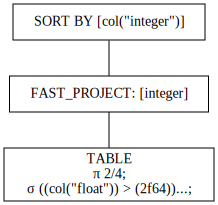

In [296]:
q.show_graph(optimized=True)

Things to note:

- You will need Graphviz installed to visualize the query plan.
- To understand the plan, you need some terminology from [relational databases](https://www.ibm.com/docs/en/informix-servers/14.10?topic=concepts-selection-projection). Namely:
  -  A _selection_ is a subset of rows, marked in the graph with a $$\sigma$$. 
  - A _projection_ is a subset of columns, marked in the graph with a $$\pi$$.
- The optimized plan removes redudancies, and orders the operations in the most efficient way.


You can now execute the plan with a `collect()`:

In [297]:
q.collect()

integer
i64
2
3


In [298]:
q.describe_plan()

'  SORT BY [col("integer")]\n     SELECT [col("integer")] FROM\n      FILTER [(col("float")) > (7f64)] FROM\n        FILTER [(col("float")) > (3f64)] FROM\n          FILTER [(col("float")) > (2f64)] FROM\n            DF ["integer", "date", "float", "string"]; PROJECT */4 COLUMNS; SELECTION: "None"\n'

For early stopping you can replace `collect()` with `fetch()`: 

In [299]:
q.fetch(2)

integer
i64
2
3


# I/O

You will find that polars is blazing fast at reading and writing data.
This is due to:

1. Very good heuristics/rules implemented in the `read_csv` function.
1. The use of [Apache Arrow](https://arrow.apache.org/) as an internal data structure, which maps seamlesly to the parquet file format.
1. Parallelism, whenever possible. 
1. Lazy scans/imports, which allows the materialization only of required data; i.e., filters and projections are executed at scan time.


## Import

### From csv

Let's firs make a csv to import:

In [300]:
df.write_csv("df.csv")

Import the csv into a non-lazy frame:

In [301]:
pl.read_csv("df.csv")

integer,date,float,string
i64,str,f64,str
1,"""2022-01-01T00:...",4.0,"""a"""
2,"""2022-01-02T00:...",5.0,"""b"""
3,"""2022-01-03T00:...",6.0,"""c"""
1,"""2022-01-04T00:...",7.0,"""d"""
2,"""2022-01-05T00:...",8.0,"""d"""
3,"""2022-01-06T00:...",9.0,"""d"""


Importing as a lazy frame:

In [302]:
df_lazy = pl.scan_csv("df.csv")

Things become interesting when you manipulate the lazy frame before materializing it:

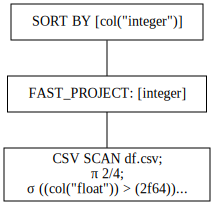

In [303]:
q = (
  df_lazy
  .filter(pl.col("float") > 2.0)
  .filter(pl.col("float") > 3.0)
  .filter(pl.col("float") > 7.0)
  .select(["integer"])
  .sort("integer")
)

q.show_graph(optimized=True)

In [304]:
q.collect()

integer
i64
2
3


Things to note:

- From the graph we see that the filtering ($$\sigma$$) is done at scan time, and not after the materialization of the data.
- To get the actual data, we naturally need to `collect()`.


### From parquet

The parquet file format is super efficient when storing data on disk. 
It is also very efficient to read and write.
In particular, it include the data's schema, so that the importing function does not need to infer it.


In [305]:
df.write_parquet("df.parquet")

The non-lazy reader:

In [306]:
pl.read_parquet("df.parquet")

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


The lazy reader:


In [307]:
pl.scan_parquet("df.parquet").collect()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


### From an Arrow DataSet

An Apache Arrow dataset is a collection of parquet files, with a common schema.
It is a very efficient way to store data on disk, and to read it in parallel.

Writing an Arrow dataset:


In [308]:
df.to_pandas().to_parquet("df", engine="pyarrow", partition_cols=["integer"])

os.listdir("df")

['integer=3', 'integer=1', 'integer=2']

In [309]:
[os.listdir(f"df/{x}/") for x in os.listdir("df")]

[['dd1d501d1c594e1684a863ddf32556ef-0.parquet',
  '9299f8f27d51472dbfd8b51cb038d61d-0.parquet'],
 ['dd1d501d1c594e1684a863ddf32556ef-0.parquet',
  '9299f8f27d51472dbfd8b51cb038d61d-0.parquet'],
 ['dd1d501d1c594e1684a863ddf32556ef-0.parquet',
  '9299f8f27d51472dbfd8b51cb038d61d-0.parquet']]

In [310]:
import pyarrow.dataset as ds
dset = ds.dataset("df", format="parquet")  
pl.scan_ds(dset).collect()

date,float,string
datetime[μs],f64,str
2022-01-01 00:00:00,4.0,"""a"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-01 00:00:00,4.0,"""a"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-02 00:00:00,5.0,"""b"""
2022-01-05 00:00:00,8.0,"""d"""
2022-01-05 00:00:00,8.0,"""d"""
2022-01-02 00:00:00,5.0,"""b"""


Things to note:

- We used pandas to write the arrow dataset. 
- The `partition_cols` argument is used to partition the dataset on disk. Each partition is a parquet file (or another partition).
- Reading from the web (not from the local filesystem) is slightly different. TODO: add reference. 


__Caution__:

The arrow data format uses caching for string and categorical data (i.e. pl.Series). 
If importing multiple files, such as multiple parquet/feather files, or an arrow dataset, different files may be cached differnetly. This will cause an error when trying to concatenate the dataframes.
To avoid this, you can disable string caching, or enforce [joint caching](https://pola-rs.github.io/polars/py-polars/html/reference/api/polars.StringCache.html) of all files. 
The latter will look like this:


In [311]:
with pl.StringCache():
  df_import = pl.scan_ds(dset).collect()
df_import

date,float,string
datetime[μs],f64,str
2022-01-01 00:00:00,4.0,"""a"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-01 00:00:00,4.0,"""a"""
2022-01-04 00:00:00,7.0,"""d"""
2022-01-02 00:00:00,5.0,"""b"""
2022-01-05 00:00:00,8.0,"""d"""
2022-01-05 00:00:00,8.0,"""d"""
2022-01-02 00:00:00,5.0,"""b"""


## Export




# Plotting

# Polars and ML

# Strings

# Datatimes


# Config


In [312]:
list(dir(pl.Config))

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'load',
 'restore_defaults',
 'save',
 'set_ascii_tables',
 'set_fmt_str_lengths',
 'set_tbl_cell_alignment',
 'set_tbl_cols',
 'set_tbl_column_data_type_inline',
 'set_tbl_dataframe_shape_below',
 'set_tbl_formatting',
 'set_tbl_hide_column_data_types',
 'set_tbl_hide_column_names',
 'set_tbl_hide_dataframe_shape',
 'set_tbl_hide_dtype_separator',
 'set_tbl_rows',
 'set_tbl_width_chars',
 'set_verbose',
 'state',
 'with_columns_kwargs']